In [7]:
import os

import numpy
from numpy import pi

from pyobjcryst.crystal import CreateCrystalFromCIF

from diffpy.srfit.pdf import PDFGenerator, DebyePDFGenerator, PDFParser
from diffpy.srfit.pdf.characteristicfunctions import sphericalCF
from diffpy.srfit.fitbase import Profile
from diffpy.srfit.fitbase import FitContribution, FitRecipe
from diffpy.srfit.fitbase import FitResults

from gaussianrecipe import scipyOptimize

from diffpy.Structure import Structure
from diffpy.srfit.fitbase.fithook import PlotFitHook

from scipy.optimize import leastsq

Code for plotting the result:

In [2]:
def plotResults(recipe):
    """Plot the results contained within a refined FitRecipe."""

    r = recipe.crystal.profile.x

    g = recipe.crystal.profile.y
    gcalc = recipe.crystal.profile.ycalc
    diffzero = -0.8 * max(g) * numpy.ones_like(g)
    diff = g - gcalc + diffzero

    import pylab
    pylab.plot(r,g,'bo',label="G(r) Data")
    pylab.plot(r, gcalc,'r-',label="G(r) Fit")
    pylab.plot(r,diff,'g-',label="G(r) diff")
    pylab.plot(r,diffzero,'k-')
    pylab.xlabel("$r (\AA)$")
    pylab.ylabel("$G (\AA^{-2})$")
    pylab.legend(loc=1)
    pylab.show()
    return

Fit recipe for alpha-ZrP structure:

In [8]:
def makeRecipe(stru1, datname):
    profile = Profile()

    parser = PDFParser()
    parser.parseFile(datname)
    profile.loadParsedData(parser)
    profile.setCalculationRange(xmin=1.0, xmax = 35.0, dx = 0.01)

# Set up PDF generator:
    generator_crystal = PDFGenerator("G_crystal")
    generator_crystal.setStructure(stru1, periodic=True)

# Generate PDF fit function:
    contribution = FitContribution("crystal")
    contribution.addProfileGenerator(generator_crystal)
    contribution.setProfile(profile, xname = "r")
    contribution.registerFunction(sphericalCF, name = "f")
    contribution.setEquation("scale * f * (G_crystal)")
    
    recipe = FitRecipe()
    recipe.addContribution(contribution)

# Experimental parameters:
    generator_crystal.setQmax(20.0)
    generator_crystal.setQmin(0.0)
    generator_crystal.qdamp.value = 0.0382204955745
    generator_crystal.qbroad.value = 0.0192369046067
    
# Profile parameters:
    recipe.addVar(contribution.scale, 7.75428239e-01, tag = "scale")
    recipe.addVar(contribution.psize, 2.09883324e+02, tag = "scale")

# Lattice parameters:
    phase_crystal = generator_crystal.phase
    lat = phase_crystal.getLattice()
    recipe.addVar(lat.a, value = 9.03452965e+00, tag = "lat")
    recipe.addVar(lat.b, value = 5.25665390e+00, tag = "lat")
    recipe.addVar(lat.c, value = 1.61981198e+01, tag = "lat")
    recipe.addVar(lat.beta, value = 1.11426367e+02, tag = "lat")

# Thermal parameters (ADPs):    
    atoms = phase_crystal.getScatterers()
    recipe.newVar("Zr_U11",  2.68210363e-03, tag = "adp")
    recipe.newVar("P_U11",  5.47293338e-03, tag = "adp")
    recipe.newVar("O_U11", 1.23405134e-02, tag = "adp")

    for atom in atoms:
        if atom.element.title() == "Zr":
            recipe.constrain(atom.Uiso, "Zr_U11")
        elif atom.element.title() == "P":
            recipe.constrain(atom.Uiso, "P_U11")
        elif atom.element.title() == "O":
            recipe.constrain(atom.Uiso, "O_U11")
            
# Correlated motion parameter:
    recipe.addVar(generator_crystal.delta1, name = "delta1_crystal", value = 8.00521167e-01, tag = "d2")

    return recipe

alpha-ZrP
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       148.91106539
Contributions  148.91106539
Restraints     0.00000000
Chi2           148.91106539
Reduced Chi2   0.04391361
Rw             0.22293443

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
O_U11           1.79407843e-02 +/- 2.28398584e-03
P_U11           5.87611686e-03 +/- 1.17200553e-03
Zr_U11          3.09522982e-03 +/- 3.86696509e-04
a               9.03581777e+00 +/- 6.6

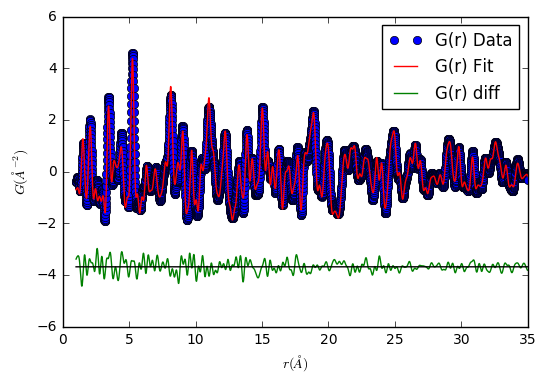

In [10]:
# Make the data and the recipe
data = "../data/PDFs/aZrP.gr"
basename = "alpha-ZrP"
print basename

# Make the recipe
from diffpy.Structure import Structure
stru1 = Structure(filename="alpha_ZrP.stru")
recipe = makeRecipe(stru1, data)
#if _plot:
#    recipe.pushFitHook(PlotFitHook())
#recipe.fithooks[0].verbose = 3


recipe.free("all")
leastsq(recipe.residual, recipe.values)

# Save structures
stru1.write(basename + ".stru", "pdffit")
profile = recipe.crystal.profile

#import IPython.Shell; IPython.Shell.IPShellEmbed(argv=[])()
profile.savetxt(basename + ".fit")

# Generate and print the FitResults
res = FitResults(recipe)
res.printResults()

header = "crystal_HF.\n"
res.saveResults(basename + ".res", header=header)

plotResults(recipe)